In [1]:
# =============================================================================
# 🚀 UNIVERSAL SCHEMA PARSER API
# Version 4.0 - Full DDL + JSON Schema Support with LLM Integration + DAG Generator
# =============================================================================

# 📦 DEPENDENCIES INSTALLATION
print("🔄 Installing dependencies...")

# Install Ollama
!curl -fsSL https://ollama.ai/install.sh | sh
# Install required packages
!pip install fastapi uvicorn pyngrok requests
!pip install "pydantic[email]" jinja2 python-multipart
# Import libraries
import subprocess
import threading
import time
import requests
import json
import logging
import re
import uuid
from typing import Dict, List, Optional, Any, Union
from pydantic import BaseModel, Field
from fastapi import FastAPI, Body, HTTPException
import uvicorn
from pyngrok import ngrok
from enum import Enum
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime

🔄 Installing dependencies...
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [2]:

# =============================================================================
# 🎯 MODEL CONFIGURATION
# =============================================================================

MODEL_CONFIG = {
    "sql_generation": "codellama:13b",
    "dag_generation": "codellama:13b"
}

# =============================================================================
# 🛠️ LOGGING CONFIGURATION
# =============================================================================

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('schema_parser.log')
    ]
)

logger = logging.getLogger("schema_parser")

# =============================================================================
# 📊 DATA MODELS
# =============================================================================

class DatabaseType(str, Enum):
    POSTGRES = "postgres"
    CLICKHOUSE = "clickhouse"

class DataSourceType(str, Enum):
    JSON_HDFS = "JsonHDFSSourceSettings"
    POSTGRESQL = "PostgreSQLDataSourceSettings"
    MYSQL = "MySQLDataSourceSettings"
    CLICKHOUSE = "ClickHouseDataSourceSettings"

class SchemaType(str, Enum):
    JSON_SCHEMA = "json_schema"
    DDL = "ddl"

class DagTemplateType(str, Enum):
    SPARK_HDFS_TO_POSTGRES = "spark_hdfs_postgres"
    SPARK_HDFS_TO_CLICKHOUSE = "spark_hdfs_clickhouse"
    POSTGRES_TO_CLICKHOUSE = "postgres_clickhouse"
    CLICKHOUSE_TO_POSTGRES = "clickhouse_postgres"
    SPARK_POSTGRES_TO_CLICKHOUSE = "spark_postgres_clickhouse"
    SPARK_CLICKHOUSE_TO_POSTGRES = "spark_clickhouse_postgres"

class TableDefinition(BaseModel):
    table_name: str
    level: int
    parent_table: Optional[str] = None
    parent_field: Optional[str] = None
    fields: List[Dict[str, Any]]
    relationship_type: Optional[str] = None
    ddl_prompt: str = ""
    source_schema_type: SchemaType

class ParserRequest(BaseModel):
    schema_input: Dict[str, Any] = Field(..., description="Входная схема данных")
    target_db: DatabaseType = Field(..., description="Тип целевой БД: postgres или clickhouse")

class ParserResponse(BaseModel):
    tables: List[TableDefinition]
    source_config: Dict[str, Any]
    target_config: Dict[str, Any]
    processing_requirements: Dict[str, Any]
    summary: Dict[str, Any]
    target_db: DatabaseType
    source_schema_type: SchemaType

class DDLCreationRequest(BaseModel):
    schema_input: Dict[str, Any] = Field(..., description="Входная схема данных")
    target_db: DatabaseType = Field(..., description="Тип целевой БД")

class DDLCreationResponse(BaseModel):
    job_id: str
    status: str = "processing"
    total_tables: int = 0
    processed_tables: int = 0
    ddl_results: List[Dict[str, Any]] = []
    error: Optional[str] = None

class DagGenerationRequest(BaseModel):
    schema_input: Dict[str, Any] = Field(..., description="Input schema from parser")
    target_db: DatabaseType = Field(..., description="Target database")
    source_type: DataSourceType = Field(..., description="Source data source type")
    dag_template: DagTemplateType = Field(..., description="DAG template type")
    ddl_results: List[Dict[str, Any]] = Field(..., description="Generated DDL statements")

class DagGenerationResponse(BaseModel):
    job_id: str
    status: str = "processing"
    dag_code: Optional[str] = None
    error: Optional[str] = None

# =============================================================================
# 🎯 NEW ORCHESTRATION MODELS
# =============================================================================

class OrchestrationRequest(BaseModel):
    schema_input: Dict[str, Any] = Field(..., description="Входная схема данных")
    target_db: DatabaseType = Field(..., description="Тип целевой БД")
    source_type: DataSourceType = Field(..., description="Тип источника данных")
    dag_template: DagTemplateType = Field(..., description="Шаблон DAG")

class PipelineVisualization(BaseModel):
    nodes: List[Dict[str, Any]]
    edges: List[Dict[str, Any]]

class OrchestrationResponse(BaseModel):
    job_id: str
    status: str = "processing"
    ddl_job_id: Optional[str] = None
    dag_job_id: Optional[str] = None
    ddl_results: Optional[List[Dict[str, Any]]] = None
    dag_code: Optional[str] = None
    pipeline_visualization: Optional[PipelineVisualization] = None
    error: Optional[str] = None
    progress: Dict[str, Any] = Field(default_factory=dict)

# =============================================================================
# 🎯 OLLAMA SETUP
# =============================================================================

def setup_ollama():
    """Start Ollama server in background"""
    logger.info("🔧 Starting Ollama server...")

    def run_ollama():
        try:
            subprocess.run(["ollama", "serve"], check=True)
        except subprocess.CalledProcessError as e:
            logger.error(f"Ollama startup error: {e}")

    ollama_thread = threading.Thread(target=run_ollama, daemon=True)
    ollama_thread.start()
    time.sleep(10)

    for i in range(3):
        try:
            response = requests.get("http://localhost:11434/api/tags", timeout=30)
            if response.status_code == 200:
                logger.info("✅ Ollama server started successfully")
                return True
        except:
            logger.warning(f"⚠️ Ollama connection attempt {i+1}/3 failed, retrying...")
            time.sleep(5)

    logger.error("❌ Could not connect to Ollama server")
    return False

def download_models():
    """Download required models"""
    models_to_download = list(MODEL_CONFIG.values())

    logger.info("📥 Downloading models...")

    for model in models_to_download:
        logger.info(f"📥 Downloading {model}...")
        try:
            process = subprocess.run(
                ["ollama", "pull", model],
                timeout=1800,
                capture_output=True,
                text=True
            )
            if process.returncode == 0:
                logger.info(f"✅ {model} downloaded successfully")
            else:
                logger.warning(f"⚠️ {model} download issues: {process.stderr}")
        except subprocess.TimeoutExpired:
            logger.warning(f"⚠️ {model} download timeout, continuing...")
        except Exception as e:
            logger.error(f"❌ Error downloading {model}: {e}")

# Initialize Ollama
setup_ollama()
logger.info("📥 Loading models...")
download_models()
time.sleep(10)

In [3]:



# =============================================================================
# 🤖 LLM CLIENT
# =============================================================================

class LLMClient:
    def __init__(self):
        self.base_url = "http://localhost:11434"
        self.timeout = 300  # 5 minutes timeout for generation

    def generate_ddl(self, prompt: str) -> str:
        """Generate DDL using SQLCoder model"""
        return self._generate_content(prompt, MODEL_CONFIG["sql_generation"])

    def generate_dag(self, prompt: str) -> str:
        """Generate DAG using CodeLlama model"""
        return self._generate_content(prompt, MODEL_CONFIG["dag_generation"])

    def _generate_content(self, prompt: str, model: str) -> str:
        """Generic content generation method"""
        try:
            payload = {
                "model": model,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": 0.1,
                    "top_k": 1,
                    "top_p": 0.1
                }
            }

            logger.info(f"🤖 Generating content with {model}...")
            response = requests.post(
                f"{self.base_url}/api/generate",
                json=payload,
                timeout=self.timeout
            )

            if response.status_code == 200:
                result = response.json()
                content = result.get("response", "").strip()

                # Clean up the response - remove any markdown code blocks
                content = re.sub(r'```python\s*', '', content)
                content = re.sub(r'```sql\s*', '', content)
                content = re.sub(r'```\s*', '', content)
                content = content.strip()

                logger.info(f"✅ Content generated successfully ({len(content)} chars)")
                return content
            else:
                logger.error(f"❌ LLM API error: {response.status_code} - {response.text}")
                return f"ERROR: LLM API returned {response.status_code}"

        except requests.exceptions.Timeout:
            logger.error("❌ LLM request timeout")
            return "ERROR: Request timeout"
        except Exception as e:
            logger.error(f"❌ LLM request failed: {str(e)}")
            return f"ERROR: {str(e)}"

# =============================================================================
# 🎯 PIPELINE VISUALIZATION GENERATOR
# =============================================================================

class PipelineVisualizationGenerator:
    """Генератор визуализации пайплайна для React Flow"""

    def __init__(self):
        self.node_counter = 0
        self.edge_counter = 0

    def generate_visualization(self, ddl_results: List[Dict[str, Any]], dag_code: str,
                            source_type: DataSourceType, target_db: DatabaseType) -> PipelineVisualization:
        """Генерация визуализации пайплайна на основе DDL и DAG"""

        logger.info("🎨 Generating pipeline visualization for React Flow...")

        nodes = []
        edges = []

        # Начальная нода - источник данных
        source_node = self._create_source_node(source_type)
        nodes.append(source_node)

        # Ноды для каждой таблицы
        table_nodes = []
        for i, ddl_result in enumerate(ddl_results):
            if ddl_result.get("status") == "completed":
                table_node = self._create_table_node(ddl_result, i)
                table_nodes.append(table_node)
                nodes.append(table_node)

                # Связь от источника к таблице
                source_to_table_edge = self._create_edge(
                    source_node["id"],
                    table_node["id"],
                    f"load_{ddl_result['table_name']}"
                )
                edges.append(source_to_table_edge)

        # Целевая нода - БД назначения
        target_node = self._create_target_node(target_db, len(table_nodes))
        nodes.append(target_node)

        # Связи от таблиц к целевой БД
        for table_node in table_nodes:
            table_to_target_edge = self._create_edge(
                table_node["id"],
                target_node["id"],
                f"store_{table_node['data']['label']}"
            )
            edges.append(table_to_target_edge)

        # Добавляем стартовую и конечную ноды
        start_node = self._create_start_node()
        end_node = self._create_end_node(len(table_nodes))
        nodes.extend([start_node, end_node])

        # Связи старта и конца
        start_to_source_edge = self._create_edge(start_node["id"], source_node["id"], "start_pipeline")
        target_to_end_edge = self._create_edge(target_node["id"], end_node["id"], "complete_pipeline")
        edges.extend([start_to_source_edge, target_to_end_edge])

        logger.info(f"✅ Visualization generated: {len(nodes)} nodes, {len(edges)} edges")

        return PipelineVisualization(nodes=nodes, edges=edges)

    def _create_source_node(self, source_type: DataSourceType) -> Dict[str, Any]:
        """Создание ноды источника данных"""
        self.node_counter += 1

        source_labels = {
            DataSourceType.JSON_HDFS: "HDFS JSON Source",
            DataSourceType.POSTGRESQL: "PostgreSQL Source",
            DataSourceType.MYSQL: "MySQL Source",
            DataSourceType.CLICKHOUSE: "ClickHouse Source"
        }

        return {
            "id": f"source_{self.node_counter}",
            "type": "input",
            "position": {"x": 100, "y": 250},
            "data": {
                "label": source_labels.get(source_type, "Data Source"),
                "type": "source",
                "source_type": source_type.value
            },
            "style": {
                "background": "#e1f5fe",
                "border": "1px solid #01579b",
                "color": "#01579b"
            }
        }

    def _create_table_node(self, ddl_result: Dict[str, Any], index: int) -> Dict[str, Any]:
        """Создание ноды для таблицы"""
        self.node_counter += 1

        table_name = ddl_result.get("table_name", f"table_{index}")
        columns_count = ddl_result.get("ddl", "").count("\\n") - 2

        return {
            "id": f"table_{self.node_counter}",
            "type": "default",
            "position": {"x": 300, "y": 100 + (index * 120)},
            "data": {
                "label": table_name,
                "type": "table",
                "columns_count": max(columns_count, 1),
                "status": ddl_result.get("status", "unknown")
            },
            "style": {
                "background": "#f3e5f5",
                "border": "1px solid #4a148c",
                "color": "#4a148c"
            }
        }

    def _create_target_node(self, target_db: DatabaseType, table_count: int) -> Dict[str, Any]:
        """Создание ноды целевой БД"""
        self.node_counter += 1

        target_labels = {
            DatabaseType.POSTGRES: "PostgreSQL Target",
            DatabaseType.CLICKHOUSE: "ClickHouse Target"
        }

        return {
            "id": f"target_{self.node_counter}",
            "type": "output",
            "position": {"x": 500, "y": 250},
            "data": {
                "label": target_labels.get(target_db, "Target Database"),
                "type": "target",
                "database_type": target_db.value,
                "table_count": table_count
            },
            "style": {
                "background": "#e8f5e8",
                "border": "1px solid #1b5e20",
                "color": "#1b5e20"
            }
        }

    def _create_start_node(self) -> Dict[str, Any]:
        """Создание стартовой ноды"""
        self.node_counter += 1
        return {
            "id": f"start_{self.node_counter}",
            "type": "input",
            "position": {"x": 0, "y": 250},
            "data": {
                "label": "Start Pipeline",
                "type": "start"
            },
            "style": {
                "background": "#c8e6c9",
                "border": "1px solid #2e7d32",
                "color": "#2e7d32"
            }
        }

    def _create_end_node(self, table_count: int) -> Dict[str, Any]:
        """Создание конечной ноды"""
        self.node_counter += 1
        return {
            "id": f"end_{self.node_counter}",
            "type": "output",
            "position": {"x": 600, "y": 250},
            "data": {
                "label": f"Complete ({table_count} tables)",
                "type": "end",
                "processed_tables": table_count
            },
            "style": {
                "background": "#ffebee",
                "border": "1px solid #c62828",
                "color": "#c62828"
            }
        }

    def _create_edge(self, source: str, target: str, label: str) -> Dict[str, Any]:
        """Создание связи между нодами"""
        self.edge_counter += 1
        return {
            "id": f"edge_{self.edge_counter}",
            "source": source,
            "target": target,
            "label": label,
            "type": "smoothstep",
            "style": {
                "stroke": "#666",
                "strokeWidth": 2
            }
        }

# =============================================================================
# 🎯 UNIVERSAL SCHEMA PARSER
# =============================================================================

class UniversalSchemaParser:
    def __init__(self, target_db: DatabaseType = DatabaseType.POSTGRES):
        self.target_db = target_db
        self.tables: List[TableDefinition] = []

    def parse_structure(self, schema_input: Dict[str, Any]) -> List[TableDefinition]:
        """Основной метод парсинга - определяет тип схемы и парсит соответственно"""
        logger.info(f"🔍 Starting schema parsing for {self.target_db.value}...")

        inputs = schema_input.get("inputs", [])
        if not inputs:
            raise ValueError("No inputs found in schema")

        input_config = inputs[0]
        schema_data = input_config.get("schema", "")

        # Определяем тип схемы
        if isinstance(schema_data, str) and "CREATE TABLE" in schema_data.upper():
            # Это DDL схема
            return self._parse_ddl_schema(schema_input, schema_data)
        elif isinstance(schema_data, dict) and "fields" in schema_data:
            # Это JSON схема
            return self._parse_json_schema(schema_input, schema_data)
        else:
            raise ValueError(f"Unknown schema format: {type(schema_data)}")

    def _parse_json_schema(self, schema_input: Dict[str, Any], schema_data: Dict) -> List[TableDefinition]:
        """Парсинг JSON схемы"""
        logger.info("📊 Parsing JSON schema structure...")

        # Создаем основную таблицу
        main_table = TableDefinition(
            table_name="main_table",
            level=1,
            fields=[],
            relationship_type="root",
            ddl_prompt="",
            source_schema_type=SchemaType.JSON_SCHEMA
        )
        self.tables.append(main_table)

        # Парсим основную схему
        self._parse_schema_level(schema_data.get("fields", []), level=1)

        # Генерируем DDL промпты для всех таблиц
        for table in self.tables:
            table.ddl_prompt = self._create_ddl_prompt(table)

        logger.info(f"✅ JSON schema parsing completed. Created {len(self.tables)} tables")
        return self.tables

    def _parse_ddl_schema(self, schema_input: Dict[str, Any], ddl_schema: str) -> List[TableDefinition]:
        """Парсинг DDL схемы"""
        logger.info("📋 Parsing DDL schema...")

        # Парсим DDL для извлечения таблиц
        tables = self._extract_tables_from_ddl(ddl_schema)

        # Создаем TableDefinition для каждой таблицы
        for table_name, table_info in tables.items():
            table_def = TableDefinition(
                table_name=table_name,
                level=1,  # Все таблицы верхнего уровня в DDL
                fields=table_info["columns"],
                relationship_type="ddl_table",
                ddl_prompt=self._create_ddl_conversion_prompt(table_name, table_info),
                source_schema_type=SchemaType.DDL
            )
            self.tables.append(table_def)

        logger.info(f"✅ DDL schema parsing completed. Created {len(self.tables)} tables")
        return self.tables

    def _extract_tables_from_ddl(self, ddl_schema: str) -> Dict[str, Any]:
        """Извлекает таблицы и колонки из DDL"""
        tables = {}

        # Простой поиск по разделению "CREATE TABLE"
        parts = re.split(r'(CREATE\s+TABLE\s+)', ddl_schema, flags=re.IGNORECASE)

        for i in range(1, len(parts), 2):
            table_block = parts[i] + parts[i+1]

            # Ищем имя таблицы и начало колонок
            name_match = re.search(r'CREATE\s+TABLE\s+(?:IF\s+NOT\s+EXISTS\s+)?([^\s(]+)', table_block, re.IGNORECASE)
            if not name_match:
                continue

            table_name = name_match.group(1).strip().strip('`"')

            # Ищем содержимое между первыми скобками
            paren_match = re.search(r'\((.*?)\)', table_block, re.DOTALL)
            if not paren_match:
                continue

            columns_str = paren_match.group(1)
            columns = self._parse_ddl_columns(columns_str)

            tables[table_name] = {
                "columns": columns,
                "full_ddl": table_block.strip()
            }

        return tables

    def _parse_ddl_columns(self, columns_str: str) -> List[Dict[str, Any]]:
        """Парсит колонки из DDL строки"""
        columns = []

        # Удаляем комментарии и лишние пробелы
        clean_str = re.sub(r'--[^\n]*|/\*.*?\*/', '', columns_str, flags=re.DOTALL)

        # Разделяем на отдельные колонки
        column_lines = []
        current_line = ""
        paren_depth = 0

        for char in clean_str:
            if char == '(':
                paren_depth += 1
            elif char == ')':
                paren_depth -= 1
            elif char == ',' and paren_depth == 0:
                if current_line.strip():
                    column_lines.append(current_line.strip())
                current_line = ""
                continue
            current_line += char

        if current_line.strip():
            column_lines.append(current_line.strip())

        for line in column_lines:
            line = line.strip()
            if not line:
                continue

            # Базовый парсинг имени колонки и типа
            parts = re.split(r'\s+', line, 2)
            if len(parts) >= 2:
                col_name = parts[0].strip('`"')
                col_type = parts[1]

                # Определяем nullable
                nullable = "NOT NULL" not in line.upper()

                # Очищаем тип от дополнительной информации
                clean_type = re.sub(
                    r'\s+NOT\s+NULL\s*|\s+NULL\s*|\s+DEFAULT\s+[^,]+|,\s*$',
                    '', col_type, flags=re.IGNORECASE
                ).strip()

                columns.append({
                    "name": col_name,
                    "type": clean_type,
                    "nullable": nullable,
                    "original_definition": line
                })

        return columns

    def _create_ddl_conversion_prompt(self, table_name: str, table_info: Dict) -> str:
        """Создает промпт для конвертации DDL между БД"""

        columns_description = ""
        for column in table_info["columns"]:
            columns_description += f"  - {column['name']}: {column['type']} (nullable: {column['nullable']})\n"

        if self.target_db == DatabaseType.POSTGRES:
            return self._create_postgres_ddl_conversion_prompt(table_name, table_info, columns_description)
        elif self.target_db == DatabaseType.CLICKHOUSE:
            return self._create_clickhouse_ddl_conversion_prompt(table_name, table_info, columns_description)

    def _create_postgres_ddl_conversion_prompt(self, table_name: str, table_info: Dict, columns_description: str) -> str:
        """Промпт для конвертации в PostgreSQL DDL"""

        prompt = f"""
TRANSLITERATION REQUIRED! No Russian characters allowed. Convert all Russian text to English:
CONVERT DDL TO POSTGRESQL FOR TABLE: {table_name}

ORIGINAL DDL:
{table_info['full_ddl']}

COLUMNS:
{columns_description}

POSTGRESQL CONVERSION REQUIREMENTS:

1. TYPE MAPPING:
   - String, LowCardinality(String) → VARCHAR or TEXT
   - UInt8, UInt16, UInt32, UInt64 → INTEGER or BIGINT
   - Int8, Int16, Int32, Int64 → SMALLINT, INTEGER, BIGINT
   - DateTime/DateTime64 → TIMESTAMP
   - Date → DATE
   - Float32, Float64 → REAL, DOUBLE PRECISION
   - Decimal → DECIMAL/NUMERIC
   - Array(Type) → Type[] or separate table
   - Enum8, Enum16 → ENUM or VARCHAR with CHECK
   - Nullable(Type) → Use NULL/NOT NULL constraints

2. TABLE STRUCTURE:
   - Remove ENGINE clauses
   - Add SERIAL primary key if needed
   - Add proper constraints

3. COMMENTS:
   - Preserve original column names and intent
   - Add comments explaining conversions

GENERATE COMPLETE POSTGRESQL DDL WITH ENGLISH NAMES ONLY. Return ONLY the DDL statement without any explanations.
"""
        return prompt

    def _create_clickhouse_ddl_conversion_prompt(self, table_name: str, table_info: Dict, columns_description: str) -> str:
        """Промпт для конвертации в ClickHouse DDL"""

        prompt = f"""
IMPORTANT: Use only English letters for table and column names.
Transliterate any Russian names to English.
CONVERT DDL TO CLICKHOUSE FOR TABLE: {table_name}

ORIGINAL DDL:
{table_info['full_ddl']}

COLUMNS:
{columns_description}

CLICKHOUSE CONVERSION REQUIREMENTS:

1. TYPE MAPPING:
   - VARCHAR, TEXT → String
   - INTEGER, BIGINT, SMALLINT → Int32, Int64, Int16
   - SERIAL → UInt32 or UInt64
   - TIMESTAMP → DateTime
   - DATE → Date
   - REAL, DOUBLE PRECISION → Float32, Float64
   - DECIMAL, NUMERIC → Decimal
   - Type[] → Array(Type)
   - ENUM → Enum8, Enum16 or String
   - BOOLEAN → UInt8

2. TABLE STRUCTURE:
   - Add appropriate ENGINE (usually MergeTree)
   - Define ORDER BY for performance
   - Add PARTITION BY if temporal data

3. ENGINE SELECTION:
   - Main tables: MergeTree family
   - Dictionaries: Dictionary
   - Logs: StripeLog, Log
   - System tables: System*

GENERATE COMPLETE CLICKHOUSE DDL WITH ENGLISH NAMES ONLY. Return ONLY the DDL statement without any explanations.
"""
        return prompt

    def _parse_schema_level(self, fields: List[Dict], level: int,
                          parent_table: str = None, parent_field: str = None):
        """Рекурсивный парсинг уровней схемы"""

        for field in fields:
            field_name = field.get("name", "")
            field_type = field.get("type", {})

            logger.info(f"Processing field: {field_name} (level {level})")

            if isinstance(field_type, dict):
                if field_type.get("type") == "array":
                    self._handle_array_field(field, level, parent_table, parent_field)
                elif field_type.get("type") == "struct":
                    self._handle_struct_field(field, level, parent_table, parent_field)
                else:
                    self._add_simple_field(field, level, parent_table)
            else:
                self._add_simple_field(field, level, parent_table)

    def _handle_array_field(self, field: Dict, level: int, parent_table: str = None, parent_field: str = None):
        """Обработка массива - создаем отдельную таблицу"""
        field_name = field.get("name", "")
        field_type = field.get("type", {})

        logger.info(f"Found array: {field_name}")

        table_name = f"{field_name}_items"
        element_type = field_type.get("elementType", {})

        if element_type.get("type") == "struct":
            struct_fields = element_type.get("fields", [])

            table_def = TableDefinition(
                table_name=table_name,
                level=level,
                parent_table=parent_table,
                parent_field=field_name,
                fields=[],
                relationship_type="array",
                ddl_prompt="",
                source_schema_type=SchemaType.JSON_SCHEMA
            )

            for struct_field in struct_fields:
                table_def.fields.append({
                    "name": struct_field.get("name"),
                    "type": struct_field.get("type"),
                    "nullable": struct_field.get("nullable", True),
                    "metadata": struct_field.get("metadata", {})
                })

            self.tables.append(table_def)
            logger.info(f"Created table for array: {table_name}")

            self._parse_nested_structures(struct_fields, level + 1, table_name, field_name)

    def _handle_struct_field(self, field: Dict, level: int, parent_table: str = None, parent_field: str = None):
        """Обработка структуры - создаем отдельную таблицу"""
        field_name = field.get("name", "")
        field_type = field.get("type", {})

        logger.info(f"Found struct: {field_name}")

        table_name = field_name
        struct_fields = field_type.get("fields", [])

        table_def = TableDefinition(
            table_name=table_name,
            level=level,
            parent_table=parent_table,
            parent_field=parent_field,
            fields=[],
            relationship_type="nested",
            ddl_prompt="",
            source_schema_type=SchemaType.JSON_SCHEMA
        )

        for struct_field in struct_fields:
            table_def.fields.append({
                "name": struct_field.get("name"),
                "type": struct_field.get("type"),
                "nullable": struct_field.get("nullable", True),
                "metadata": struct_field.get("metadata", {})
            })

        self.tables.append(table_def)
        logger.info(f"Created table for struct: {table_name}")

        self._parse_nested_structures(struct_fields, level + 1, table_name, field_name)

    def _parse_nested_structures(self, fields: List[Dict], level: int, parent_table: str, parent_field: str):
        """Рекурсивный парсинг вложенных структур"""
        for field in fields:
            field_type = field.get("type", {})

            if isinstance(field_type, dict):
                if field_type.get("type") == "struct":
                    self._handle_struct_field(field, level, parent_table, parent_field)
                elif field_type.get("type") == "array":
                    self._handle_array_field(field, level, parent_table, parent_field)

    def _add_simple_field(self, field: Dict, level: int, parent_table: str = None):
        """Добавление простого поля в таблицу"""
        field_name = field.get("name", "")

        if level == 1:
            main_table = next((t for t in self.tables if t.table_name == "main_table"), None)
            if main_table:
                main_table.fields.append({
                    "name": field_name,
                    "type": field.get("type"),
                    "nullable": field.get("nullable", True),
                    "metadata": field.get("metadata", {})
                })

    def _create_ddl_prompt(self, table_def: TableDefinition) -> str:
        """Создание промпта для генерации DDL с учетом типа БД"""

        if self.target_db == DatabaseType.POSTGRES:
            return self._create_postgres_ddl_prompt(table_def)
        elif self.target_db == DatabaseType.CLICKHOUSE:
            return self._create_clickhouse_ddl_prompt(table_def)
        else:
            return self._create_generic_ddl_prompt(table_def)

    def _create_postgres_ddl_prompt(self, table_def: TableDefinition) -> str:
        """Упрощенный промпт для PostgreSQL"""

        fields_description = ""
        for field in table_def.fields:
            original_name = field['name']
            field_type = self._get_field_type_description(field["type"])

            fields_description += f"  - {original_name}: {field_type} (nullable: {field['nullable']})\n"

            if field.get("metadata", {}).get("examples"):
                examples = field["metadata"]["examples"][:2]
                fields_description += f"    Examples: {examples}\n"

        prompt = f"""
    CREATE POSTGRESQL TABLE: {table_def.table_name}

    COLUMNS:
    {fields_description}
    """

        if table_def.parent_table:
            prompt += f"\nADD FOREIGN KEY to parent table: {table_def.parent_table}"

        prompt += "\n\nGENERATE COMPLETE POSTGRESQL CREATE TABLE STATEMENT."
        return prompt

    def _create_clickhouse_ddl_prompt(self, table_def: TableDefinition) -> str:
        """Упрощенный промпт для ClickHouse"""

        fields_description = ""
        for field in table_def.fields:
            original_name = field['name']
            field_type = self._get_field_type_description(field["type"])

            fields_description += f"  - {original_name}: {field_type} (nullable: {field['nullable']})\n"

            if field.get("metadata", {}).get("examples"):
                examples = field["metadata"]["examples"][:2]
                fields_description += f"    Examples: {examples}\n"

        prompt = f"""
    CREATE CLICKHOUSE TABLE: {table_def.table_name}

    COLUMNS:
    {fields_description}
    """

        if table_def.parent_table:
            prompt += f"\nADD FOREIGN KEY to parent table: {table_def.parent_table}"

        prompt += "\n\nGENERATE COMPLETE CLICKHOUSE CREATE TABLE STATEMENT."
        return prompt

    def _get_field_type_description(self, field_type: Union[str, Dict]) -> str:
        """Получение описания типа поля"""
        if isinstance(field_type, str):
            return field_type

        if isinstance(field_type, dict):
            return field_type.get("type", "unknown")

        return "unknown"

# =============================================================================
# 🚀 DAG GENERATION SERVICE
# =============================================================================

class DagGenerationService:
    def __init__(self):
        self.llm_client = LLMClient()
        self.jobs: Dict[str, Dict] = {}

    def create_dag_job(self, request: DagGenerationRequest) -> str:
        """Create a new DAG generation job"""
        job_id = str(uuid.uuid4())

        self.jobs[job_id] = {
            "status": "processing",
            "dag_code": None,
            "error": None,
            "request": request.dict()
        }

        # Start processing in background thread
        thread = threading.Thread(target=self._process_dag_generation, args=(job_id,), daemon=True)
        thread.start()

        logger.info(f"🚀 Started DAG generation job {job_id}")
        return job_id

    def _process_dag_generation(self, job_id: str):
        """Process DAG generation in background"""
        try:
            job = self.jobs[job_id]
            request_data = job["request"]

            logger.info(f"🔄 Starting DAG generation for job {job_id}")

            # Create DAG template based on source and target
            template = self._create_dag_template(
                request_data["source_type"],
                request_data["target_db"],
                request_data["dag_template"],
                request_data["schema_input"],
                request_data["ddl_results"]
            )

            # Generate DAG code using LLM
            dag_code = self.llm_client.generate_dag(template)

            # Clean and validate the generated code
            cleaned_code = self._clean_dag_code(dag_code)

            job["dag_code"] = cleaned_code
            job["status"] = "completed"
            logger.info(f"✅ DAG generation completed for job {job_id}")

        except Exception as e:
            logger.error(f"❌ DAG generation job {job_id} failed: {str(e)}")
            self.jobs[job_id]["status"] = "failed"
            self.jobs[job_id]["error"] = str(e)

    def _create_dag_template(self, source_type: DataSourceType, target_db: DatabaseType,
                          dag_template: DagTemplateType, schema_input: Dict, ddl_results: List[Dict]) -> str:
        """Create simplified DAG template for LLM"""

        # Extract source and target configurations
        source_config = self._extract_source_config(schema_input, source_type)
        target_config = self._extract_target_config(schema_input, target_db)

        # Get table information from DDL results
        tables_info = self._extract_tables_info(ddl_results)

        # Extract DDL statements for each table
        ddl_statements = {}
        for result in ddl_results:
            if (result.get("status") == "completed" and
                result.get("table_name") and
                result.get("ddl")):
                ddl_statements[result["table_name"]] = result["ddl"]

        # Base template
        base_template = self._get_base_dag_template(dag_template)

        # SIMPLIFIED PROMPT
        prompt = f"""
    CREATE AN AIRFLOW DAG FOR ETL PIPELINE:

    SOURCE: {source_type.value} -> TARGET: {target_db.value}

    TABLES: {[table['table_name'] for table in tables_info]}

    DDL STATEMENTS:
    {json.dumps(ddl_statements, indent=2)}

    BASE TEMPLATE:
    {base_template}

    CREATE THESE TASKS FOR EACH TABLE:

    1. PostgresOperator to create table using DDL above
    2. SparkSubmitOperator to process data
    3. Set dependency: create_table >> process_data

    EXAMPLE:
    create_users = PostgresOperator(
        task_id='create_users',
        sql='CREATE TABLE users (id BIGINT)'
    )

    process_users = SparkSubmitOperator(
        task_id='process_users',
        application='/opt/spark/apps/etl.py',
        application_args=['--table', 'users']
    )

    create_users >> process_users

IMPORTANT:
- Transliterate all Russian names to English (e.g., 'ГРНИПДата' -> 'grnip_data')
- Use realistic HDFS paths like '/data/input/'
- Add start and end dummy tasks
- Use 'CREATE TABLE IF NOT EXISTS' in DDL
- IMPORT DummyOperator: from airflow.operators.dummy import DummyOperator
- TABLE DEPENDENCIES: Each create_table task must run before its process_table task
- START/END: Include start_dag and end_dag DummyOperator tasks
- Connect ALL process_table tasks to end_dag
CRITICAL: RESPECT FOREIGN KEY DEPENDENCIES!
- If table B has FOREIGN KEY to table A, then: create_table_A >> create_table_B
- Example: 'grnipdata' references 'inf_okved_opt_items' → create_inf_okved_opt_items >> create_grnipdata
- This is mandatory for database integrity

EXAMPLE DEPENDENCIES:
create_users >> process_users
create_orders >> process_orders

    RETURN COMPLETE PYTHON CODE.
    """
        return prompt

    def _extract_source_config(self, schema_input: Dict, source_type: DataSourceType) -> Dict:
        """Extract source configuration from schema input"""
        inputs = schema_input.get("inputs", [])
        if not inputs:
            return {}

        source_settings = inputs[0].get("settings", {})

        config = {
            "source_type": source_type.value,
            "settings": source_settings
        }

        # Add specific configurations based on source type
        if source_type == DataSourceType.JSON_HDFS:
            config.update({
                "file_format": "json",
                "path_pattern": source_settings.get("path", ""),
                "compression": source_settings.get("compression", "none")
            })
        elif source_type == DataSourceType.POSTGRESQL:
            config.update({
                "host": source_settings.get("host", ""),
                "database": source_settings.get("database", ""),
                "schema": source_settings.get("schema", "public")
            })
        elif source_type == DataSourceType.CLICKHOUSE:
            config.update({
                "host": source_settings.get("host", ""),
                "database": source_settings.get("database", ""),
                "cluster": source_settings.get("cluster", "")
            })

        return config

    def _extract_target_config(self, schema_input: Dict, target_db: DatabaseType) -> Dict:
        """Extract target configuration from schema input"""
        output = schema_input.get("output", {})
        target_settings = output.get("settings", {})

        config = {
            "target_type": target_db.value,
            "settings": target_settings
        }

        if target_db == DatabaseType.POSTGRES:
            config.update({
                "host": target_settings.get("host", ""),
                "database": target_settings.get("database", ""),
                "schema": target_settings.get("schema", "public")
            })
        elif target_db == DatabaseType.CLICKHOUSE:
            config.update({
                "host": target_settings.get("host", ""),
                "database": target_settings.get("database", ""),
                "cluster": target_settings.get("cluster", ""),
                "engine": target_settings.get("engine", "MergeTree")
            })

        return config

    def _extract_tables_info(self, ddl_results: List[Dict]) -> List[Dict]:
        """Extract table information from DDL results"""
        tables = []

        for result in ddl_results:
            if result.get("status") == "completed":
                table_info = {
                    "table_name": result["table_name"],
                    "ddl_preview": result["ddl"][:200] + "..." if len(result["ddl"]) > 200 else result["ddl"],
                    "columns_count": result["ddl"].count("\\n") - 2  # Rough estimate
                }
                tables.append(table_info)

        return tables

    def _get_base_dag_template(self, dag_template: DagTemplateType) -> str:
        """Get base DAG template based on template type"""

        templates = {
            DagTemplateType.SPARK_HDFS_TO_POSTGRES: """
# SPARK + HDFS to PostgreSQL DAG Template
from airflow.operators.dummy import DummyOperator
from airflow import DAG
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from airflow.providers.postgres.operators.postgres import PostgresOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook
from datetime import datetime, timedelta
import json

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'spark_hdfs_to_postgres',
    default_args=default_args,
    description='Load data from HDFS to PostgreSQL using Spark',
    schedule_interval='@daily',
    catchup=False,
    tags=['etl', 'spark', 'postgres']
)

def create_spark_task(table_name, hdfs_path, postgres_table):
    return SparkSubmitOperator(
        task_id=f'process_{table_name}',
        application='/path/to/your/spark/job.py',
        name=f'spark_{table_name}',
        conn_id='spark_default',
        application_args=[
            '--hdfs-path', hdfs_path,
            '--postgres-table', postgres_table,
            '--config', '{{ ti.xcom_pull(key="config") }}'
        ],
        dag=dag
    )

# Add your tasks here
""",

            DagTemplateType.SPARK_HDFS_TO_CLICKHOUSE: """
# SPARK + HDFS to ClickHouse DAG Template
from airflow.operators.dummy import DummyOperator
from airflow import DAG
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from airflow.providers.clickhouse.operators.clickhouse import ClickHouseOperator
from airflow.providers.clickhouse.hooks.clickhouse import ClickHouseHook
from datetime import datetime, timedelta
import json

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'spark_hdfs_to_clickhouse',
    default_args=default_args,
    description='Load data from HDFS to ClickHouse using Spark',
    schedule_interval='@daily',
    catchup=False,
    tags=['etl', 'spark', 'clickhouse']
)

def create_clickhouse_operator(task_id, sql):
    return ClickHouseOperator(
        task_id=task_id,
        sql=sql,
        clickhouse_conn_id='clickhouse_default',
        dag=dag
    )

# Add your tasks here
""",

            DagTemplateType.POSTGRES_TO_CLICKHOUSE: """
# PostgreSQL to ClickHouse DAG Template
from airflow.operators.dummy import DummyOperator
from airflow import DAG
from airflow.providers.postgres.operators.postgres import PostgresOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.providers.clickhouse.operators.clickhouse import ClickHouseOperator
from airflow.providers.clickhouse.hooks.clickhouse import ClickHouseHook
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta
import pandas as pd

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'postgres_to_clickhouse',
    default_args=default_args,
    description='Transfer data from PostgreSQL to ClickHouse',
    schedule_interval='@daily',
    catchup=False,
    tags=['etl', 'postgres', 'clickhouse']
)

def transfer_table(postgres_table, clickhouse_table):
    def transfer_func(**context):
        postgres_hook = PostgresHook(postgres_conn_id='postgres_default')
        clickhouse_hook = ClickHouseHook(clickhouse_conn_id='clickhouse_default')

        # Read from PostgreSQL
        df = postgres_hook.get_pandas_df(f'SELECT * FROM {postgres_table}')

        # Write to ClickHouse
        clickhouse_hook.insert_rows(
            table=clickhouse_table,
            rows=df.values.tolist(),
            column_names=df.columns.tolist()
        )

    return PythonOperator(
        task_id=f'transfer_{postgres_table}',
        python_callable=transfer_func,
        dag=dag
    )

# Add your tasks here
""",

            DagTemplateType.CLICKHOUSE_TO_POSTGRES: """
# ClickHouse to PostgreSQL DAG Template
from airflow.operators.dummy import DummyOperator
from airflow import DAG
from airflow.providers.clickhouse.operators.clickhouse import ClickHouseOperator
from airflow.providers.clickhouse.hooks.clickhouse import ClickHouseHook
from airflow.providers.postgres.operators.postgres import PostgresOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta
import pandas as pd

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'clickhouse_to_postgres',
    default_args=default_args,
    description='Transfer data from ClickHouse to PostgreSQL',
    schedule_interval='@daily',
    catchup=False,
    tags=['etl', 'clickhouse', 'postgres']
)

def transfer_table(clickhouse_table, postgres_table):
    def transfer_func(**context):
        clickhouse_hook = ClickHouseHook(clickhouse_conn_id='clickhouse_default')
        postgres_hook = PostgresHook(postgres_conn_id='postgres_default')

        # Read from ClickHouse
        df = clickhouse_hook.get_pandas_df(f'SELECT * FROM {clickhouse_table}')

        # Write to PostgreSQL
        postgres_hook.insert_rows(
            table=postgres_table,
            rows=df.values.tolist(),
            target_fields=df.columns.tolist()
        )

    return PythonOperator(
        task_id=f'transfer_{clickhouse_table}',
        python_callable=transfer_func,
        dag=dag
    )

# Add your tasks here
"""
        }

        return templates.get(dag_template, """
# Generic ETL DAG Template
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.operators.dummy import DummyOperator
from datetime import datetime, timedelta

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'etl_pipeline',
    default_args=default_args,
    description='ETL Pipeline',
    schedule_interval='@daily',
    catchup=False,
    tags=['etl']
)

# Add your tasks here
""")

    def _clean_dag_code(self, dag_code: str) -> str:
        """Clean and validate generated DAG code"""
        # Remove markdown code blocks
        clean_code = re.sub(r'```python\s*', '', dag_code)
        clean_code = re.sub(r'```\s*', '', clean_code)

        # Remove any explanatory text before/after code
        lines = clean_code.split('\n')
        code_lines = []
        in_code = False

        for line in lines:
            if line.strip().startswith('from ') or line.strip().startswith('import ') or line.strip().startswith('def ') or line.strip().startswith('class ') or line.strip().startswith('dag = DAG'):
                in_code = True
            if in_code:
                code_lines.append(line)

        clean_code = '\n'.join(code_lines).strip()

        # Basic validation - check for essential DAG components
        if 'DAG(' not in clean_code:
            clean_code = f"""
# WARNING: Generated code might be incomplete. Adding basic DAG structure.

from airflow import DAG
from datetime import datetime

{clean_code}
"""

        return clean_code

    def get_job_status(self, job_id: str) -> Optional[Dict]:
        """Get job status by ID"""
        return self.jobs.get(job_id)

# =============================================================================
# 🚀 DDL GENERATION SERVICE
# =============================================================================

class DDLGenerationService:
    def __init__(self):
        self.llm_client = LLMClient()
        self.jobs: Dict[str, Dict] = {}

    def clean_and_transliterate_ddl(self, ddl: str, target_db: DatabaseType) -> str:
        """Пост-обработка DDL - транслитерация ВСЕХ русских букв в английские"""

        # Словарь транслитерации
        translit_map = {
            'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e',
            'ё': 'yo', 'ж': 'zh', 'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k',
            'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p', 'р': 'r',
            'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'kh', 'ц': 'ts',
            'ч': 'ch', 'ш': 'sh', 'щ': 'shch', 'ъ': '', 'ы': 'y', 'ь': '',
            'э': 'e', 'ю': 'yu', 'я': 'ya',
            'А': 'a', 'Б': 'b', 'В': 'v', 'Г': 'g', 'Д': 'd', 'Е': 'e',
            'Ё': 'yo', 'Ж': 'zh', 'З': 'z', 'И': 'i', 'Й': 'y', 'К': 'k',
            'Л': 'l', 'М': 'm', 'Н': 'n', 'О': 'o', 'П': 'p', 'Р': 'r',
            'С': 's', 'Т': 't', 'У': 'u', 'Ф': 'f', 'Х': 'kh', 'Ц': 'ts',
            'Ч': 'ch', 'Ш': 'sh', 'Щ': 'shch', 'Ъ': '', 'Ы': 'y', 'Ь': '',
            'Э': 'e', 'Ю': 'yu', 'Я': 'ya'
        }

        def transliterate_text(text: str) -> str:
            """Транслитерирует русский текст в английский"""
            result = ''
            for char in text:
                result += translit_map.get(char, char)
            return result

        # 👇 ПРОСТО ТРАНСЛИТЕРИРУЕМ ВСЮ DDL СТРОКУ
        return transliterate_text(ddl)

    def clean_ddl_response(self, ddl: str) -> str:
        """Очистка ответа от лишнего текста и неверных типов"""
        # Убираем пояснительный текст
        clean_ddl = re.sub(r'Here is the complete PostgreSQL create table statement.*?:\s*', '', ddl, flags=re.IGNORECASE)
        clean_ddl = re.sub(r'Note that.*', '', clean_ddl, flags=re.IGNORECASE | re.DOTALL)

        # Исправляем неверные типы PostgreSQL
        clean_ddl = clean_ddl.replace('STRING', 'TEXT')
        clean_ddl = clean_ddl.replace('STRUCT', 'TEXT')  # STRUCT не поддерживается в PostgreSQL

        return clean_ddl.strip()

    def create_ddl_job(self, request: DDLCreationRequest) -> str:
        """Create a new DDL generation job"""
        job_id = str(uuid.uuid4())

        # Parse schema to get DDL prompts
        parser = UniversalSchemaParser(target_db=request.target_db)
        tables = parser.parse_structure(request.schema_input)

        self.jobs[job_id] = {
            "status": "processing",
            "total_tables": len(tables),
            "processed_tables": 0,
            "ddl_results": [],
            "tables": tables,
            "target_db": request.target_db
        }

        # Start processing in background thread
        thread = threading.Thread(target=self._process_ddl_generation, args=(job_id,), daemon=True)
        thread.start()

        logger.info(f"🚀 Started DDL generation job {job_id} in background thread")
        return job_id

    def _process_ddl_generation(self, job_id: str):
        """Process DDL generation in background"""
        try:
            job = self.jobs[job_id]
            tables = job["tables"]
            target_db = job["target_db"]  # ← ПОЛУЧИЛИ target_db

            logger.info(f"🔄 Starting DDL generation for job {job_id} with {len(tables)} tables")

            # Process tables sequentially for reliability
            for i, table in enumerate(tables):
                logger.info(f"🤖 Processing table {i+1}/{len(tables)}: {table.table_name}")

                # 👇 ПЕРЕДАЙ target_db в вызов
                ddl_result = self._generate_single_ddl(table.ddl_prompt, table.table_name, target_db)

                job["ddl_results"].append({
                    "table_name": table.table_name,
                    "ddl": ddl_result,
                    "status": "completed" if not ddl_result.startswith("ERROR") else "failed"
                })

                job["processed_tables"] = i + 1
                logger.info(f"📊 Progress: {i+1}/{len(tables)} tables processed")

            job["status"] = "completed"
            logger.info(f"✅ DDL generation completed for job {job_id}")

        except Exception as e:
            logger.error(f"❌ DDL generation job {job_id} failed: {str(e)}")
            self.jobs[job_id]["status"] = "failed"
            self.jobs[job_id]["error"] = str(e)

    def _generate_single_ddl(self, prompt: str, table_name: str, target_db: DatabaseType) -> str:
        """Generate DDL for a single table"""
        logger.info(f"🤖 Generating DDL for table: {table_name}")
        raw_ddl = self.llm_client.generate_ddl(prompt)
        cleaned_ddl = self.clean_ddl_response(raw_ddl)

        # 👇 ПЕРЕДАВАЙ target_db как параметр
        transliterated_ddl = self.clean_and_transliterate_ddl(cleaned_ddl, target_db)

        return transliterated_ddl

    def get_job_status(self, job_id: str) -> Optional[Dict]:
        """Get job status by ID"""
        return self.jobs.get(job_id)

# =============================================================================
# 🚀 ORCHESTRATION SERVICE
# =============================================================================

class OrchestrationService:
    def __init__(self):
        self.ddl_service = DDLGenerationService()
        self.dag_service = DagGenerationService()
        self.visualization_generator = PipelineVisualizationGenerator()
        self.jobs: Dict[str, Dict] = {}

    def create_orchestration_job(self, request: OrchestrationRequest) -> str:
        """Create a new orchestration job"""
        job_id = str(uuid.uuid4())

        self.jobs[job_id] = {
            "status": "processing",
            "ddl_job_id": None,
            "dag_job_id": None,
            "ddl_results": None,
            "dag_code": None,
            "pipeline_visualization": None,
            "error": None,
            "progress": {
                "current_step": "starting",
                "ddl_progress": "0/0",
                "dag_progress": "waiting"
            },
            "request": request.dict()
        }

        # Start processing in background thread
        thread = threading.Thread(target=self._process_orchestration, args=(job_id,), daemon=True)
        thread.start()

        logger.info(f"🚀 Started orchestration job {job_id}")
        return job_id

    def _process_orchestration(self, job_id: str):
        """Process orchestration in background"""
        try:
            job = self.jobs[job_id]
            request_data = job["request"]

            logger.info(f"🔄 Starting orchestration for job {job_id}")

            # Step 1: Generate DDL
            job["progress"]["current_step"] = "generating_ddl"
            ddl_request = DDLCreationRequest(
                schema_input=request_data["schema_input"],
                target_db=request_data["target_db"]
            )

            ddl_job_id = self.ddl_service.create_ddl_job(ddl_request)
            job["ddl_job_id"] = ddl_job_id
            logger.info(f"📋 DDL job created: {ddl_job_id}")

            # Wait for DDL completion (synchronous waiting)
            job["progress"]["current_step"] = "waiting_for_ddl"
            ddl_results = self._wait_for_ddl_completion(ddl_job_id)

            if not ddl_results:
                raise Exception("DDL generation failed or timed out")

            job["ddl_results"] = ddl_results
            logger.info(f"✅ DDL generation completed: {len(ddl_results)} tables")

            # Step 2: Generate DAG
            job["progress"]["current_step"] = "generating_dag"
            dag_request = DagGenerationRequest(
                schema_input=request_data["schema_input"],
                target_db=request_data["target_db"],
                source_type=request_data["source_type"],
                dag_template=request_data["dag_template"],
                ddl_results=ddl_results
            )

            dag_job_id = self.dag_service.create_dag_job(dag_request)
            job["dag_job_id"] = dag_job_id
            logger.info(f"📋 DAG job created: {dag_job_id}")

            # Wait for DAG completion (synchronous waiting)
            job["progress"]["current_step"] = "waiting_for_dag"
            dag_code = self._wait_for_dag_completion(dag_job_id)

            if not dag_code:
                raise Exception("DAG generation failed or timed out")

            job["dag_code"] = dag_code
            logger.info(f"✅ DAG generation completed")

            # Step 3: Generate Pipeline Visualization
            job["progress"]["current_step"] = "generating_visualization"
            visualization = self.visualization_generator.generate_visualization(
                ddl_results=ddl_results,
                dag_code=dag_code,
                source_type=request_data["source_type"],
                target_db=request_data["target_db"]
            )

            job["pipeline_visualization"] = visualization
            job["status"] = "completed"
            logger.info(f"✅ Orchestration completed for job {job_id}")

        except Exception as e:
            logger.error(f"❌ Orchestration job {job_id} failed: {str(e)}")
            self.jobs[job_id]["status"] = "failed"
            self.jobs[job_id]["error"] = str(e)

    def _wait_for_ddl_completion(self, ddl_job_id: str, timeout_seconds: int = 1800) -> Optional[List[Dict]]:
        """Wait for DDL job completion (synchronous)"""
        logger.info(f"⏳ Waiting for DDL job {ddl_job_id}...")

        start_time = time.time()
        last_progress = 0

        while time.time() - start_time < timeout_seconds:
            try:
                job_status = self.ddl_service.get_job_status(ddl_job_id)

                if not job_status:
                    logger.error(f"DDL job {ddl_job_id} not found")
                    return None

                current_status = job_status["status"]
                processed = job_status["processed_tables"]
                total = job_status["total_tables"]

                # Update progress if changed
                if processed != last_progress:
                    logger.info(f"📊 DDL progress: {processed}/{total} tables")
                    last_progress = processed

                if current_status == "completed":
                    logger.info(f"✅ DDL job {ddl_job_id} completed successfully")
                    return job_status["ddl_results"]
                elif current_status == "failed":
                    logger.error(f"❌ DDL job {ddl_job_id} failed: {job_status.get('error')}")
                    return None

                # Wait before next check
                time.sleep(10)

            except Exception as e:
                logger.error(f"Error checking DDL job status: {e}")
                time.sleep(10)

        logger.error(f"⏰ DDL job {ddl_job_id} timed out after {timeout_seconds} seconds")
        return None

    def _wait_for_dag_completion(self, dag_job_id: str, timeout_seconds: int = 600) -> Optional[str]:
        """Wait for DAG job completion (synchronous)"""
        logger.info(f"⏳ Waiting for DAG job {dag_job_id}...")

        start_time = time.time()

        while time.time() - start_time < timeout_seconds:
            try:
                job_status = self.dag_service.get_job_status(dag_job_id)

                if not job_status:
                    logger.error(f"DAG job {dag_job_id} not found")
                    return None

                current_status = job_status["status"]

                if current_status == "completed":
                    logger.info(f"✅ DAG job {dag_job_id} completed successfully")
                    return job_status["dag_code"]
                elif current_status == "failed":
                    logger.error(f"❌ DAG job {dag_job_id} failed: {job_status.get('error')}")
                    return None

                # Wait before next check
                time.sleep(5)

            except Exception as e:
                logger.error(f"Error checking DAG job status: {e}")
                time.sleep(5)

        logger.error(f"⏰ DAG job {dag_job_id} timed out after {timeout_seconds} seconds")
        return None

    def get_job_status(self, job_id: str) -> Optional[Dict]:
        """Get orchestration job status"""
        return self.jobs.get(job_id)

# =============================================================================
# 🚀 FASTAPI APPLICATION
# =============================================================================

app = FastAPI(
    title="Universal Schema Parser API",
    description="API для парсинга JSON схем и DDL с конвертацией между БД и генерацией DAG",
    version="4.0"
)

ddl_service = DDLGenerationService()
dag_service = DagGenerationService()
orchestration_service = OrchestrationService()

@app.post("/parse-schema", response_model=ParserResponse)
async def parse_schema(request: ParserRequest = Body(...)):
    """Парсинг схемы и генерация DDL промптов для указанной БД"""
    logger.info(f"🎯 Starting schema parsing for {request.target_db.value}")

    try:
        schema_input = request.schema_input

        # Извлекаем конфигурации
        inputs = schema_input.get("inputs", [])
        output_config = schema_input.get("output", {})
        processing_req = schema_input.get("processing_requirements", {})

        if not inputs:
            raise HTTPException(status_code=400, detail="No inputs found in schema")

        source_config = inputs[0].get("settings", {})

        # Создаем парсер и парсим схему
        parser = UniversalSchemaParser(target_db=request.target_db)
        tables = parser.parse_structure(schema_input)

        # Определяем тип исходной схемы
        schema_type = tables[0].source_schema_type if tables else SchemaType.JSON_SCHEMA

        # Формируем сводную информацию
        summary = {
            "total_tables": len(tables),
            "levels": len(set(table.level for table in tables)),
            "total_fields": sum(len(table.fields) for table in tables),
            "array_tables": len([t for t in tables if t.relationship_type == "array"]),
            "nested_tables": len([t for t in tables if t.relationship_type == "nested"]),
            "ddl_tables": len([t for t in tiles if t.relationship_type == "ddl_table"]),
            "source_schema_type": schema_type.value
        }

        logger.info(f"✅ Parsing completed: {summary['total_tables']} tables created")

        return ParserResponse(
            tables=tables,
            source_config=source_config,
            target_config=output_config,
            processing_requirements=processing_req,
            summary=summary,
            target_db=request.target_db,
            source_schema_type=schema_type
        )

    except Exception as e:
        logger.error(f"❌ Parsing error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"Parsing failed: {str(e)}")

@app.post("/generate-ddl", response_model=DDLCreationResponse)
async def generate_ddl(request: DDLCreationRequest = Body(...)):
    """Генерация DDL через LLM"""
    logger.info(f"🚀 Starting DDL generation for {request.target_db.value}")

    try:
        job_id = ddl_service.create_ddl_job(request)

        return DDLCreationResponse(
            job_id=job_id,
            status="processing",
            total_tables=ddl_service.jobs[job_id]["total_tables"],
            processed_tables=0
        )

    except Exception as e:
        logger.error(f"❌ DDL generation error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"DDL generation failed: {str(e)}")

@app.post("/generate-dag", response_model=DagGenerationResponse)
async def generate_dag(request: DagGenerationRequest = Body(...)):
    """Генерация DAG через LLM"""
    logger.info(f"🚀 Starting DAG generation for {request.source_type.value} -> {request.target_db.value}")

    try:
        job_id = dag_service.create_dag_job(request)

        return DagGenerationResponse(
            job_id=job_id,
            status="processing"
        )

    except Exception as e:
        logger.error(f"❌ DAG generation error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"DAG generation failed: {str(e)}")

@app.post("/orchestrate", response_model=OrchestrationResponse)
async def orchestrate_pipeline(request: OrchestrationRequest = Body(...)):
    """Оркестрация полного пайплайна: DDL + DAG генерация + визуализация"""
    logger.info(f"🚀 Starting orchestration for {request.source_type.value} -> {request.target_db.value}")

    try:
        job_id = orchestration_service.create_orchestration_job(request)

        return OrchestrationResponse(
            job_id=job_id,
            status="processing",
            ddl_job_id=orchestration_service.jobs[job_id]["ddl_job_id"],
            progress=orchestration_service.jobs[job_id]["progress"]
        )

    except Exception as e:
        logger.error(f"❌ Orchestration error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"Orchestration failed: {str(e)}")

@app.get("/ddl-job-status/{job_id}")
async def get_ddl_job_status(job_id: str):
    """Получить статус DDL генерации"""
    job = ddl_service.get_job_status(job_id)

    if not job:
        raise HTTPException(status_code=404, detail="Job not found")

    return job

@app.get("/dag-job-status/{job_id}")
async def get_dag_job_status(job_id: str):
    """Получить статус DAG генерации"""
    job = dag_service.get_job_status(job_id)

    if not job:
        raise HTTPException(status_code=404, detail="Job not found")

    return job

@app.get("/orchestration-job-status/{job_id}")
async def get_orchestration_job_status(job_id: str):
    """Получить статус оркестрации"""
    job = orchestration_service.get_job_status(job_id)

    if not job:
        raise HTTPException(status_code=404, detail="Job not found")

    return job

@app.get("/health")
async def health_check():
    """Health check endpoint"""
    return {
        "status": "healthy",
        "service": "Universal Schema Parser",
        "version": "4.0",
        "supported_databases": [db.value for db in DatabaseType],
        "supported_schema_types": [schema_type.value for schema_type in SchemaType],
        "supported_dag_templates": [template.value for template in DagTemplateType]
    }

# =============================================================================
# 🚀 SERVER STARTUP
# =============================================================================

def run_server():
    """Run FastAPI server"""
    uvicorn.run(app, host="0.0.0.0", port=9008)

# Start server in background thread
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

logger.info("⏳ Starting Universal Schema Parser server...")
time.sleep(5)

# =============================================================================
# 🔗 NGROK TUNNEL
# =============================================================================

NGROK_AUTH_TOKEN = "338TA70xtNay5va50xHiY5qVx3P_85mA2w23gDC18FxqQt67f"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

try:
    public_tunnel = ngrok.connect(9008, bind_tls=True)
    public_url = public_tunnel.public_url
    logger.info(f"✅ Universal Schema Parser started!")
    logger.info(f"🌐 Public URL: {public_url}")

    print(f"\n🎯 UNIVERSAL SCHEMA PARSER API READY!")
    print(f"🌐 Public URL: {public_url}")
    print(f"📚 Swagger Docs: {public_url}/docs")
    print(f"\n📋 AVAILABLE ENDPOINTS:")
    print(f"   POST {public_url}/parse-schema       - Parse any schema format")
    print(f"   POST {public_url}/generate-ddl      - Generate DDL via LLM")
    print(f"   POST {public_url}/generate-dag      - Generate DAG via LLM")
    print(f"   POST {public_url}/orchestrate       - Full pipeline orchestration")
    print(f"   GET  {public_url}/ddl-job-status/{{job_id}} - Check DDL generation status")
    print(f"   GET  {public_url}/dag-job-status/{{job_id}} - Check DAG generation status")
    print(f"   GET  {public_url}/orchestration-job-status/{{job_id}} - Check orchestration status")
    print(f"   GET  {public_url}/health             - Service status")

    print(f"\n🎯 SUPPORTED SCHEMA FORMATS:")
    print(f"   • JSON Schema - структура с полями и типами")
    print(f"   • DDL         - готовый CREATE TABLE statements")

    print(f"\n🎯 SUPPORTED DATABASES:")
    print(f"   • postgres    - PostgreSQL DDL generation")
    print(f"   • clickhouse  - ClickHouse DDL generation")

    print(f"\n🎯 SUPPORTED DAG TEMPLATES:")
    print(f"   • spark_hdfs_postgres       - Spark + HDFS → PostgreSQL")
    print(f"   • spark_hdfs_clickhouse     - Spark + HDFS → ClickHouse")
    print(f"   • postgres_clickhouse       - PostgreSQL → ClickHouse")
    print(f"   • clickhouse_postgres       - ClickHouse → PostgreSQL")

    print(f"\n🎯 NEW FEATURE: Pipeline Visualization for React Flow")
    print(f"   • Automatically generates nodes and edges for frontend")
    print(f"   • Includes source, table, target, start and end nodes")
    print(f"   • Ready-to-use React Flow configuration")

except Exception as e:
    logger.error(f"❌ Ngrok error: {e}")
    print(f"❌ Ngrok failed: {e}")
    print("📡 Server running locally on http://localhost:9008")

# =============================================================================
# 🎯 MONITORING TOOLS
# =============================================================================

def monitor_ddl_job(job_id, base_url="http://localhost:9008"):
    """Мониторинг статуса DDL генерации"""
    import time
    from datetime import datetime

    print(f"🔍 Started monitoring DDL job: {job_id}")
    print(f"⏰ Start time: {datetime.now().strftime('%H:%M:%S')}")

    last_processed = 0
    stuck_count = 0

    while True:
        try:
            response = requests.get(f"{base_url}/ddl-job-status/{job_id}", timeout=30)
            data = response.json()

            status = data["status"]
            processed = data["processed_tables"]
            total = data["total_tables"]
            progress = f"{processed}/{total}"

            # Проверка на зависание
            if processed == last_processed:
                stuck_count += 1
            else:
                stuck_count = 0
                last_processed = processed

            print(f"🕒 {datetime.now().strftime('%H:%M:%S')} | Status: {status:10} | Tables: {progress:8} | Stuck: {stuck_count}")

            # Детальная информация о текущей обработке
            if data.get("ddl_results"):
                recent_results = data["ddl_results"][-3:]  # Последние 3 таблицы
                for result in recent_results:
                    table = result["table_name"]
                    result_status = result["status"]
                    print(f"   📋 {table}: {result_status}")

            # Завершение мониторинга
            if status in ["completed", "failed"]:
                if status == "completed":
                    print(f"🎉 SUCCESS: Generated {len(data['ddl_results'])} DDL statements")
                    # Показать первые 3 DDL
                    for i, result in enumerate(data['ddl_results'][:3]):
                        print(f"   {i+1}. {result['table_name']}: {result['ddl'][:100]}...")
                else:
                    print(f"❌ FAILED: {data.get('error', 'Unknown error')}")
                break

            # Предупреждение о возможном зависании
            if stuck_count > 6:  # 60 секунд без прогресса
                print("🚨 WARNING: Job might be stuck! No progress for 60+ seconds")
                print("💡 Try checking Ollama logs or restarting the service")

            time.sleep(10)  # Проверка каждые 10 секунд

        except requests.exceptions.Timeout:
            print("⏰ Timeout: Service might be overloaded")
            stuck_count += 1
        except Exception as e:
            print(f"❌ Monitoring error: {e}")
            break

def monitor_dag_job(job_id, base_url="http://localhost:9008"):
    """Мониторинг статуса DAG генерации"""
    import time
    from datetime import datetime

    print(f"🔍 Started monitoring DAG job: {job_id}")
    print(f"⏰ Start time: {datetime.now().strftime('%H:%M:%S')}")

    check_count = 0

    while True:
        try:
            response = requests.get(f"{base_url}/dag-job-status/{job_id}", timeout=30)
            data = response.json()

            status = data["status"]
            check_count += 1

            print(f"🕒 {datetime.now().strftime('%H:%M:%S')} | Status: {status:10} | Checks: {check_count}")

            if status == "completed":
                print(f"🎉 SUCCESS: DAG generated successfully!")
                if data.get("dag_code"):
                    print(f"📝 Code preview: {data['dag_code'][:200]}...")
                break
            elif status == "failed":
                print(f"❌ FAILED: {data.get('error', 'Unknown error')}")
                break

            # DAG generation is usually faster than DDL
            if check_count > 18:  # 3 minutes timeout
                print("🚨 TIMEOUT: DAG generation taking too long")
                break

            time.sleep(10)  # Проверка каждые 10 секунд

        except requests.exceptions.Timeout:
            print("⏰ Timeout: Service might be overloaded")
            check_count += 1
        except Exception as e:
            print(f"❌ Monitoring error: {e}")
            break

def monitor_orchestration_job(job_id, base_url="http://localhost:9008"):
    """Мониторинг статуса оркестрации"""
    import time
    from datetime import datetime

    print(f"🔍 Started monitoring orchestration job: {job_id}")
    print(f"⏰ Start time: {datetime.now().strftime('%H:%M:%S')}")

    last_step = ""
    check_count = 0

    while True:
        try:
            response = requests.get(f"{base_url}/orchestration-job-status/{job_id}", timeout=30)
            data = response.json()

            status = data["status"]
            current_step = data.get("progress", {}).get("current_step", "unknown")
            ddl_job_id = data.get("ddl_job_id")
            dag_job_id = data.get("dag_job_id")

            if current_step != last_step:
                print(f"🔄 Step changed: {current_step}")
                last_step = current_step

            print(f"🕒 {datetime.now().strftime('%H:%M:%S')} | Status: {status:10} | Step: {current_step:20} | Check: {check_count}")

            if ddl_job_id:
                print(f"   📋 DDL Job: {ddl_job_id}")
            if dag_job_id:
                print(f"   📋 DAG Job: {dag_job_id}")

            # Завершение мониторинга
            if status == "completed":
                print(f"🎉 SUCCESS: Orchestration completed!")
                if data.get("dag_code"):
                    print(f"📝 DAG code preview: {data['dag_code'][:200]}...")
                if data.get("ddl_results"):
                    print(f"📊 Generated {len(data['ddl_results'])} DDL statements")
                if data.get("pipeline_visualization"):
                    viz = data["pipeline_visualization"]
                    print(f"🎨 Visualization: {len(viz['nodes'])} nodes, {len(viz['edges'])} edges")
                break
            elif status == "failed":
                print(f"❌ FAILED: {data.get('error', 'Unknown error')}")
                break

            check_count += 1
            if check_count > 60:  # 10 minutes timeout
                print("🚨 TIMEOUT: Orchestration taking too long")
                break

            time.sleep(10)  # Проверка каждые 10 секунд

        except requests.exceptions.Timeout:
            print("⏰ Timeout: Service might be overloaded")
            check_count += 1
        except Exception as e:
            print(f"❌ Monitoring error: {e}")
            break

print("\n🎯 USAGE EXAMPLE:")
print('''
# 1. Simple orchestration - one call for everything
orchestration_request = {
    "schema_input": {... your schema ...},
    "target_db": "postgres",
    "source_type": "JsonHDFSSourceSettings",
    "dag_template": "spark_hdfs_postgres"
}

response = requests.post("http://localhost:9008/orchestrate", json=orchestration_request)
job_data = response.json()
job_id = job_data["job_id"]

# 2. Monitor the orchestration job
monitor_orchestration_job(job_id)

# 3. Get final results
final_response = requests.get(f"http://localhost:9008/orchestration-job-status/{job_id}")
final_data = final_response.json()

if final_data["status"] == "completed":
    dag_code = final_data["dag_code"]
    ddl_results = final_data["ddl_results"]
    visualization = final_data["pipeline_visualization"]

    print("✅ Pipeline completed successfully!")
    print(f"📝 DAG code length: {len(dag_code)}")
    print(f"📊 DDL statements: {len(ddl_results)}")
    print(f"🎨 React Flow nodes: {len(visualization['nodes'])}")
    print(f"🎨 React Flow edges: {len(visualization['edges'])}")

    # Use on frontend with React Flow:
    # const initialNodes = visualization.nodes;
    # const initialEdges = visualization.edges;
''')

INFO:     Started server process [19419]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:9008 (Press CTRL+C to quit)



🎯 UNIVERSAL SCHEMA PARSER API READY!
🌐 Public URL: https://pilar-unnormative-gil.ngrok-free.dev
📚 Swagger Docs: https://pilar-unnormative-gil.ngrok-free.dev/docs

📋 AVAILABLE ENDPOINTS:
   POST https://pilar-unnormative-gil.ngrok-free.dev/parse-schema       - Parse any schema format
   POST https://pilar-unnormative-gil.ngrok-free.dev/generate-ddl      - Generate DDL via LLM
   POST https://pilar-unnormative-gil.ngrok-free.dev/generate-dag      - Generate DAG via LLM
   POST https://pilar-unnormative-gil.ngrok-free.dev/orchestrate       - Full pipeline orchestration
   GET  https://pilar-unnormative-gil.ngrok-free.dev/ddl-job-status/{job_id} - Check DDL generation status
   GET  https://pilar-unnormative-gil.ngrok-free.dev/dag-job-status/{job_id} - Check DAG generation status
   GET  https://pilar-unnormative-gil.ngrok-free.dev/orchestration-job-status/{job_id} - Check orchestration status
   GET  https://pilar-unnormative-gil.ngrok-free.dev/health             - Service status

🎯 SUPP

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00
✅ Данные пайплайна загружены!
• Нод: 7
• Связей: 8

🎨 Создаем Plotly визуализацию...



🕸️ Создаем NetworkX визуализацию...


/tmp/ipython-input-1883369225.py:461: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



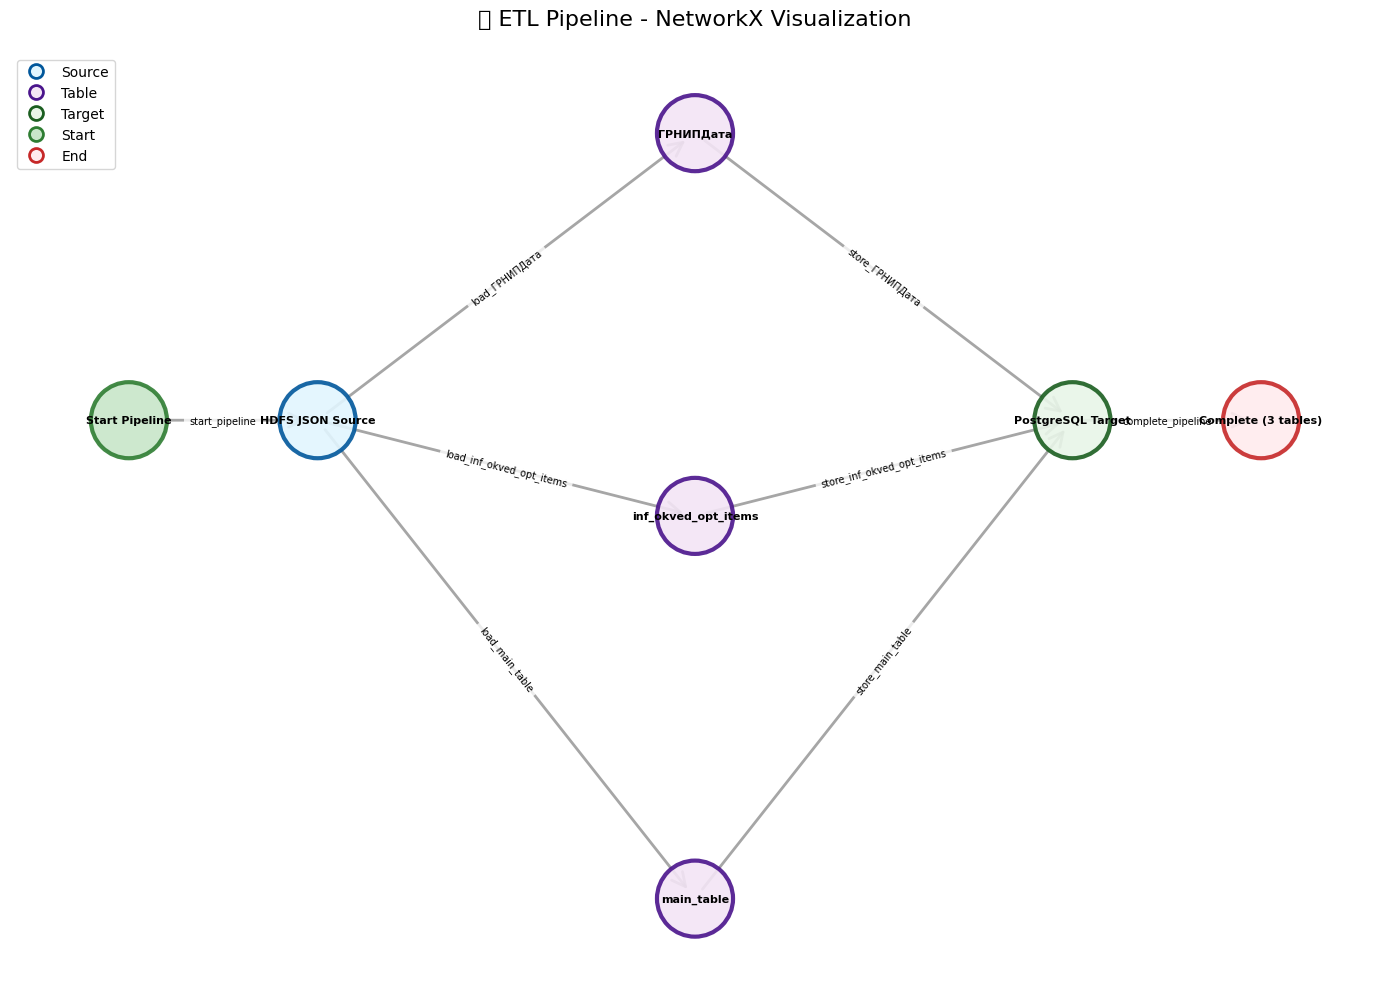


📋 ТЕКСТОВАЯ ВИЗУАЛИЗАЦИЯ ПАЙПЛАЙНА

🏗️  СТРУКТУРА ПАЙПЛАЙНА:
┌─── 🚀 START
│
├─── 📁 SOURCE: HDFS JSON Source
│     ├─── 🗂️  TABLE: main_table
│     ├─── 🗂️  TABLE: inf_okved_opt_items
│     └─── 🗂️  TABLE: ГРНИПДата
│
├─── 🎯 TARGET: PostgreSQL Target
│
└─── ✅ END: Complete (3 tables)

🔄 ПОТОК ДАННЫХ:
   1. HDFS JSON Source          → main_table
   2. HDFS JSON Source          → inf_okved_opt_items
   3. HDFS JSON Source          → ГРНИПДата
   4. main_table                → PostgreSQL Target
   5. inf_okved_opt_items       → PostgreSQL Target
   6. ГРНИПДата                 → PostgreSQL Target
   7. Start Pipeline            → HDFS JSON Source
   8. PostgreSQL Target         → Complete (3 tables)

🎮 ИНТЕРАКТИВНЫЙ ПРОСМОТР:



📊 СТАТИСТИКА ПАЙПЛАЙНА:
📈 ТИПЫ НОД:
• source    :  1 нод
• table     :  3 нод
• target    :  1 нод
• start     :  1 нод
• end       :  1 нод

🔗 ТИПЫ СВЯЗЕЙ:
• source→table   :  3 связей
• table→target   :  3 связей
• start→source   :  1 связей
• target→end     :  1 связей

✅ ПАЙПЛАЙН УСПЕШНО СОЗДАН!
• Источник: HDFS JSON → Цель: PostgreSQL
• Обрабатывается 3 таблицы
• Визуализация готова для React Flow


In [4]:
# Установка необходимых библиотек
!pip install networkx matplotlib plotly
!pip install ipywidgets

import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import json

# Данные визуализации пайплайна
pipeline_data = {
    "nodes": [
      {
        "id": "source_1",
        "type": "input",
        "position": {
          "x": 100,
          "y": 250
        },
        "data": {
          "label": "HDFS JSON Source",
          "type": "source",
          "source_type": "JsonHDFSSourceSettings"
        },
        "style": {
          "background": "#e1f5fe",
          "border": "1px solid #01579b",
          "color": "#01579b"
        }
      },
      {
        "id": "table_2",
        "type": "default",
        "position": {
          "x": 300,
          "y": 100
        },
        "data": {
          "label": "main_table",
          "type": "table",
          "columns_count": 1,
          "status": "completed"
        },
        "style": {
          "background": "#f3e5f5",
          "border": "1px solid #4a148c",
          "color": "#4a148c"
        }
      },
      {
        "id": "table_3",
        "type": "default",
        "position": {
          "x": 300,
          "y": 220
        },
        "data": {
          "label": "inf_okved_opt_items",
          "type": "table",
          "columns_count": 1,
          "status": "completed"
        },
        "style": {
          "background": "#f3e5f5",
          "border": "1px solid #4a148c",
          "color": "#4a148c"
        }
      },
      {
        "id": "table_4",
        "type": "default",
        "position": {
          "x": 300,
          "y": 340
        },
        "data": {
          "label": "ГРНИПДата",
          "type": "table",
          "columns_count": 1,
          "status": "completed"
        },
        "style": {
          "background": "#f3e5f5",
          "border": "1px solid #4a148c",
          "color": "#4a148c"
        }
      },
      {
        "id": "target_5",
        "type": "output",
        "position": {
          "x": 500,
          "y": 250
        },
        "data": {
          "label": "PostgreSQL Target",
          "type": "target",
          "database_type": "postgres",
          "table_count": 3
        },
        "style": {
          "background": "#e8f5e8",
          "border": "1px solid #1b5e20",
          "color": "#1b5e20"
        }
      },
      {
        "id": "start_6",
        "type": "input",
        "position": {
          "x": 0,
          "y": 250
        },
        "data": {
          "label": "Start Pipeline",
          "type": "start"
        },
        "style": {
          "background": "#c8e6c9",
          "border": "1px solid #2e7d32",
          "color": "#2e7d32"
        }
      },
      {
        "id": "end_7",
        "type": "output",
        "position": {
          "x": 600,
          "y": 250
        },
        "data": {
          "label": "Complete (3 tables)",
          "type": "end",
          "processed_tables": 3
        },
        "style": {
          "background": "#ffebee",
          "border": "1px solid #c62828",
          "color": "#c62828"
        }
      }
    ],
    "edges": [
      {
        "id": "edge_1",
        "source": "source_1",
        "target": "table_2",
        "label": "load_main_table",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_2",
        "source": "source_1",
        "target": "table_3",
        "label": "load_inf_okved_opt_items",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_3",
        "source": "source_1",
        "target": "table_4",
        "label": "load_ГРНИПДата",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_4",
        "source": "table_2",
        "target": "target_5",
        "label": "store_main_table",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_5",
        "source": "table_3",
        "target": "target_5",
        "label": "store_inf_okved_opt_items",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_6",
        "source": "table_4",
        "target": "target_5",
        "label": "store_ГРНИПДата",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_7",
        "source": "start_6",
        "target": "source_1",
        "label": "start_pipeline",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      },
      {
        "id": "edge_8",
        "source": "target_5",
        "target": "end_7",
        "label": "complete_pipeline",
        "type": "smoothstep",
        "style": {
          "stroke": "#666",
          "strokeWidth": 2
        }
      }
    ]
}

print("✅ Данные пайплайна загружены!")
print(f"• Нод: {len(pipeline_data['nodes'])}")
print(f"• Связей: {len(pipeline_data['edges'])}")

# 1. ВИЗУАЛИЗАЦИЯ С PLOTLY (самая красивая)
def create_pipeline_visualization_plotly(pipeline_data):
    """Создание красивой визуализации пайплайна с помощью Plotly"""

    nodes = pipeline_data['nodes']
    edges = pipeline_data['edges']

    # Создаем фигуру
    fig = go.Figure()

    # Цвета для разных типов нод
    node_colors = {
        'source': '#e1f5fe',
        'table': '#f3e5f5',
        'target': '#e8f5e8',
        'start': '#c8e6c9',
        'end': '#ffebee'
    }

    border_colors = {
        'source': '#01579b',
        'table': '#4a148c',
        'target': '#1b5e20',
        'start': '#2e7d32',
        'end': '#c62828'
    }

    # Добавляем ноды
    for node in nodes:
        node_type = node['data']['type']
        fig.add_trace(go.Scatter(
            x=[node['position']['x']],
            y=[node['position']['y']],
            mode='markers+text',
            marker=dict(
                size=50,
                color=node_colors[node_type],
                line=dict(width=3, color=border_colors[node_type])
            ),
            text=[node['data']['label']],
            textposition="middle center",
            name=node_type.capitalize(),
            hovertemplate=f'<b>{node["data"]["label"]}</b><br>Type: {node_type}<extra></extra>',
            showlegend=False
        ))

    # Добавляем связи (edges)
    for edge in edges:
        source_node = next(node for node in nodes if node['id'] == edge['source'])
        target_node = next(node for node in nodes if node['id'] == edge['target'])

        # Линия
        fig.add_trace(go.Scatter(
            x=[source_node['position']['x'], target_node['position']['x']],
            y=[source_node['position']['y'], target_node['position']['y']],
            mode='lines',
            line=dict(width=3, color='#666666'),
            hoverinfo='none',
            showlegend=False
        ))

        # Стрелка
        fig.add_annotation(
            x=target_node['position']['x'],
            y=target_node['position']['y'],
            ax=source_node['position']['x'],
            ay=source_node['position']['y'],
            xref='x', yref='y',
            axref='x', ayref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=1.5,
            arrowwidth=2,
            arrowcolor='#666666'
        )

        # Подпись связи (по середине)
        mid_x = (source_node['position']['x'] + target_node['position']['x']) / 2
        mid_y = (source_node['position']['y'] + target_node['position']['y']) / 2

        fig.add_annotation(
            x=mid_x,
            y=mid_y,
            text=edge['label'],
            showarrow=False,
            font=dict(size=10, color='white'),
            bgcolor="rgba(0,0,0,0.8)",
            bordercolor="black",
            borderwidth=1,
            borderpad=4
        )

    # Настройка внешнего вида
    fig.update_layout(
        title=dict(
            text="🎯 ETL Pipeline Visualization",
            x=0.5,
            font=dict(size=20, color='#2c3e50')
        ),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-50, 700]
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[0, 400]
        ),
        plot_bgcolor='white',
        showlegend=False,
        width=900,
        height=600,
        margin=dict(l=50, r=50, t=80, b=50),
        annotations=[]
    )

    # Добавляем легенду вручную
    legend_elements = []
    y_pos = 380
    for node_type, color in node_colors.items():
        fig.add_annotation(
            x=650, y=y_pos,
            text=f"● {node_type.upper()}",
            showarrow=False,
            font=dict(size=12, color=border_colors[node_type]),
            bgcolor=color,
            bordercolor=border_colors[node_type],
            borderwidth=2,
            borderpad=8
        )
        y_pos -= 30

    return fig

print("\n🎨 Создаем Plotly визуализацию...")
fig = create_pipeline_visualization_plotly(pipeline_data)
fig.show()

# 2. ВИЗУАЛИЗАЦИЯ С NETWORKX (графовая)
def create_networkx_visualization(pipeline_data):
    """Создание графовой визуализации с NetworkX"""

    # Создаем направленный граф
    G = nx.DiGraph()

    # Добавляем ноды с атрибутами
    for node in pipeline_data['nodes']:
        G.add_node(
            node['id'],
            label=node['data']['label'],
            type=node['data']['type'],
            pos=(node['position']['x'], node['position']['y'])
        )

    # Добавляем связи
    for edge in pipeline_data['edges']:
        G.add_edge(edge['source'], edge['target'], label=edge['label'])

    # Создаем график
    plt.figure(figsize=(14, 10))

    # Позиции нод
    pos = {node['id']: (node['position']['x'], node['position']['y']) for node in pipeline_data['nodes']}

    # Цвета для разных типов нод
    node_colors = []
    node_border_colors = []
    for node in pipeline_data['nodes']:
        node_type = node['data']['type']
        if node_type == 'source':
            node_colors.append('#e1f5fe')
            node_border_colors.append('#01579b')
        elif node_type == 'table':
            node_colors.append('#f3e5f5')
            node_border_colors.append('#4a148c')
        elif node_type == 'target':
            node_colors.append('#e8f5e8')
            node_border_colors.append('#1b5e20')
        elif node_type == 'start':
            node_colors.append('#c8e6c9')
            node_border_colors.append('#2e7d32')
        else:  # end
            node_colors.append('#ffebee')
            node_border_colors.append('#c62828')

    # Рисуем ноды
    nx.draw_networkx_nodes(G, pos,
                          node_size=3000,
                          node_color=node_colors,
                          edgecolors=node_border_colors,
                          linewidths=3,
                          alpha=0.9)

    # Рисуем связи
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=25,
                          arrowstyle='->',
                          width=2,
                          alpha=0.7)

    # Рисуем подписи нод
    labels = {node['id']: node['data']['label'] for node in pipeline_data['nodes']}
    nx.draw_networkx_labels(G, pos, labels=labels,
                           font_size=8,
                           font_weight='bold')

    # Добавляем подписи связей
    edge_labels = {(edge['source'], edge['target']): edge['label'] for edge in pipeline_data['edges']}
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_size=7,
                                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    plt.title("🔄 ETL Pipeline - NetworkX Visualization", size=16, pad=20)
    plt.axis('off')
    plt.tight_layout()

    # Добавляем легенду
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e1f5fe', markersize=10, markeredgecolor='#01579b', markeredgewidth=2, label='Source'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#f3e5f5', markersize=10, markeredgecolor='#4a148c', markeredgewidth=2, label='Table'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e8f5e8', markersize=10, markeredgecolor='#1b5e20', markeredgewidth=2, label='Target'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c8e6c9', markersize=10, markeredgecolor='#2e7d32', markeredgewidth=2, label='Start'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffebee', markersize=10, markeredgecolor='#c62828', markeredgewidth=2, label='End')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

    plt.show()

print("\n🕸️ Создаем NetworkX визуализацию...")
create_networkx_visualization(pipeline_data)

# 3. ТЕКСТОВАЯ ВИЗУАЛИЗАЦИЯ
def create_text_visualization(pipeline_data):
    """Текстовая визуализация пайплайна"""
    print("\n" + "="*70)
    print("📋 ТЕКСТОВАЯ ВИЗУАЛИЗАЦИЯ ПАЙПЛАЙНА")
    print("="*70)

    print("\n🏗️  СТРУКТУРА ПАЙПЛАЙНА:")
    print("┌─── 🚀 START")
    print("│")
    print("├─── 📁 SOURCE: HDFS JSON Source")
    print("│     ├─── 🗂️  TABLE: main_table")
    print("│     ├─── 🗂️  TABLE: inf_okved_opt_items")
    print("│     └─── 🗂️  TABLE: ГРНИПДата")
    print("│")
    print("├─── 🎯 TARGET: PostgreSQL Target")
    print("│")
    print("└─── ✅ END: Complete (3 tables)")

    print("\n🔄 ПОТОК ДАННЫХ:")
    for i, edge in enumerate(pipeline_data['edges'], 1):
        source_label = next(node['data']['label'] for node in pipeline_data['nodes'] if node['id'] == edge['source'])
        target_label = next(node['data']['label'] for node in pipeline_data['nodes'] if node['id'] == edge['target'])
        print(f"  {i:2d}. {source_label:25} → {target_label}")

create_text_visualization(pipeline_data)

# 4. ИНТЕРАКТИВНЫЙ ПРОСМОТРЩИК
def create_interactive_viewer(pipeline_data):
    """Создание интерактивного просмотрщика данных"""

    print("\n🎮 ИНТЕРАКТИВНЫЙ ПРОСМОТР:")

    # Создаем выпадающий список для выбора ноды
    node_options = [(node['data']['label'], node) for node in pipeline_data['nodes']]
    node_dropdown = widgets.Dropdown(
        options=node_options,
        description='Выберите ноду:',
        style={'description_width': 'initial'}
    )

    # Создаем текстовое поле для отображения информации
    info_output = widgets.Output()

    def on_node_change(change):
        with info_output:
            info_output.clear_output()
            node = change['new']
            print(f"🔍 ДЕТАЛИ НОДЫ:")
            print(f"• ID: {node['id']}")
            print(f"• Label: {node['data']['label']}")
            print(f"• Type: {node['data']['type']}")
            print(f"• Position: ({node['position']['x']}, {node['position']['y']})")

            # Дополнительные поля в зависимости от типа
            if 'source_type' in node['data']:
                print(f"• Source Type: {node['data']['source_type']}")
            if 'columns_count' in node['data']:
                print(f"• Columns: {node['data']['columns_count']}")
            if 'database_type' in node['data']:
                print(f"• Database: {node['data']['database_type']}")
            if 'table_count' in node['data']:
                print(f"• Tables: {node['data']['table_count']}")
            if 'processed_tables' in node['data']:
                print(f"• Processed: {node['data']['processed_tables']}")

            # Показываем входящие и исходящие связи
            print(f"\n🔗 СВЯЗИ:")
            incoming = [edge for edge in pipeline_data['edges'] if edge['target'] == node['id']]
            outgoing = [edge for edge in pipeline_data['edges'] if edge['source'] == node['id']]

            if incoming:
                print(f"• Входящие: {len(incoming)}")
                for edge in incoming:
                    source_label = next(n['data']['label'] for n in pipeline_data['nodes'] if n['id'] == edge['source'])
                    print(f"  ← {source_label} ({edge['label']})")

            if outgoing:
                print(f"• Исходящие: {len(outgoing)}")
                for edge in outgoing:
                    target_label = next(n['data']['label'] for n in pipeline_data['nodes'] if n['id'] == edge['target'])
                    print(f"  → {target_label} ({edge['label']})")

    node_dropdown.observe(on_node_change, names='value')

    # Инициализируем с первой нодой
    node_dropdown.value = pipeline_data['nodes'][0]

    return widgets.VBox([node_dropdown, info_output])

# Запускаем интерактивный просмотрщик
interactive_viewer = create_interactive_viewer(pipeline_data)
display(interactive_viewer)

# 5. СТАТИСТИКА ПАЙПЛАЙНА
print("\n📊 СТАТИСТИКА ПАЙПЛАЙНА:")
print("="*50)

# Статистика по типам нод
node_types = {}
for node in pipeline_data['nodes']:
    node_type = node['data']['type']
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("📈 ТИПЫ НОД:")
for node_type, count in node_types.items():
    print(f"• {node_type:10}: {count:2} нод")

# Статистика по связям
edge_stats = {}
for edge in pipeline_data['edges']:
    source_type = next(node['data']['type'] for node in pipeline_data['nodes'] if node['id'] == edge['source'])
    target_type = next(node['data']['type'] for node in pipeline_data['nodes'] if node['id'] == edge['target'])
    connection = f"{source_type}→{target_type}"
    edge_stats[connection] = edge_stats.get(connection, 0) + 1

print("\n🔗 ТИПЫ СВЯЗЕЙ:")
for connection, count in edge_stats.items():
    print(f"• {connection:15}: {count:2} связей")

print(f"\n✅ ПАЙПЛАЙН УСПЕШНО СОЗДАН!")
print("• Источник: HDFS JSON → Цель: PostgreSQL")
print("• Обрабатывается 3 таблицы")
print("• Визуализация готова для React Flow")

In [5]:
# 🔄 KEEP-ALIVE LOOP FOR SERVER AND SESSION
import time
import threading

def keep_alive():
    """Простой цикл для поддержания активности сервера и сессии"""
    while True:
        print(f"🕒 Session alive at {time.strftime('%H:%M:%S')}")
        time.sleep(60)  # Сообщение каждую минуту

# Запускаем в фоновом потоке
keep_alive_thread = threading.Thread(target=keep_alive, daemon=True)
keep_alive_thread.start()

print("✅ Keep-alive loop started - server will stay active")

🕒 Session alive at 13:58:06
✅ Keep-alive loop started - server will stay active
